In [3]:
import os

# Define paths for input images and ground truth masks
input_dir = os.path.join("..", "dataset_my", "MSFD", "1", "face_crop")
gt_dir = os.path.join("..", "dataset_my", "MSFD", "1", "face_crop_segmentation")



```markdown
## Image Segmentation Workflow

This notebook demonstrates an image segmentation workflow using region growing and Otsu's thresholding methods. The steps involved are:

1. **Import Libraries**: Import necessary libraries such as `os`, `cv2`, `numpy`, `matplotlib`, and others.
2. **Define Paths**: Set up paths for input images and ground truth masks.
3. **Check File Existence**: Verify the existence of image and mask files.
4. **Segmentation Functions**:
    - `segment_region_growing`: Perform segmentation using region growing via flood fill.
    - `segment_otsu_thresholding`: Perform segmentation using Otsu's thresholding and morphological processing.
5. **Visualization**: Display the original image, segmented region, and edges.
6. **Compute Metrics**: Calculate Intersection over Union (IoU) and Dice Score between predicted and ground truth masks.
7. **Batch Processing**: Iterate through all images in the input folder, perform segmentation, and compute evaluation metrics.
8. **Results**: Display average IoU and Dice scores for the processed images.

This workflow helps in evaluating the performance of different segmentation techniques on a dataset of face images.
```

In [4]:
import os
import cv2


image_path = '../dataset_my/MSFD/1/face_crop/000000_1.jpg'
true_mask_path = '../dataset_my/MSFD/1/face_crop_segmentation/000000_1.jpg'

print("Image exists:", os.path.exists(image_path))
print("Mask exists:", os.path.exists(true_mask_path))


Image exists: True
Mask exists: True


In [5]:
import os
import cv2
import numpy as np  #Fix: Add NumPy
import matplotlib.pyplot as plt
from skimage.morphology import binary_closing, disk
from skimage.segmentation import flood
from skimage.util import img_as_ubyte
from sklearn.cluster import KMeans


In [6]:
!pip install opencv-python


### Region-Based Segmentation Using Flood Fill  
This function performs segmentation using a region-growing approach with flood fill.  
- **Inputs:**  
  - `image_path`: Path to the input image.  
  - `tolerance`: Controls the growth of the region (default = 0.4).  
  - `viz`: Boolean flag to visualize results.  
  - `save_result`: Boolean flag to save the segmented mask.  
  - `save_path`: Path to save the output mask if `save_result` is True.  
- **Process:**  
  1. Load and preprocess the image (convert to grayscale, blur, normalize).  
  2. Select a seed point (image center) and perform region growing.  
  3. Convert the segmented region into a binary mask.  
  4. Apply morphological operations and edge detection.  
  5. Optionally visualize and save the results.  
- **Output:**  
  - Returns the segmented binary mask.  


In [7]:
def segment_region_growing(image_path, tolerance=0.4, viz=False, save_result=False, save_path=None):
    """Perform segmentation using region growing via flood fill."""
    
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    grayscale = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(grayscale, (17, 17), 8)
    normalized = blurred.astype(np.float32) / 255.0  

    # Select seed point (center of image)
    h, w = normalized.shape
    seed = (h // 2, w // 2)
    
    # Perform region growing
    binary_mask = flood(normalized, seed, tolerance=tolerance)

    # Convert to binary mask (0 or 255)
    processed_mask = img_as_ubyte(binary_mask)
    processed_mask = binary_closing(processed_mask, disk(3)).astype(np.uint8) * 255

    # Apply edge detection
    edges = cv2.Canny(processed_mask, 50, 150)

    # Visualization
    if viz:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(image_rgb)
        ax[0].set_title("Original Image")
        ax[0].axis("off")

        ax[1].imshow(processed_mask, cmap="gray")
        ax[1].set_title("Segmented Region")
        ax[1].axis("off")

        ax[2].imshow(edges, cmap="gray")
        ax[2].set_title("Edges")
        ax[2].axis("off")

        plt.show()
    
    # Save result if required
    if save_result and save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        cv2.imwrite(save_path, processed_mask)

    return processed_mask

### Visualizing the Segmented Mask  
This script applies the `segment_region_growing` function to an input image and visualizes the output.  
- **Process:**  
  1. Calls `segment_region_growing` with `viz=True` to enable visualization.  
  2. Checks if the function returns a valid mask.  
  3. If valid, displays the segmented mask using `matplotlib`.  
- **Expected Output:**  
  - A grayscale image showing the segmented mask.  
  - If segmentation fails, an error message is printed.  


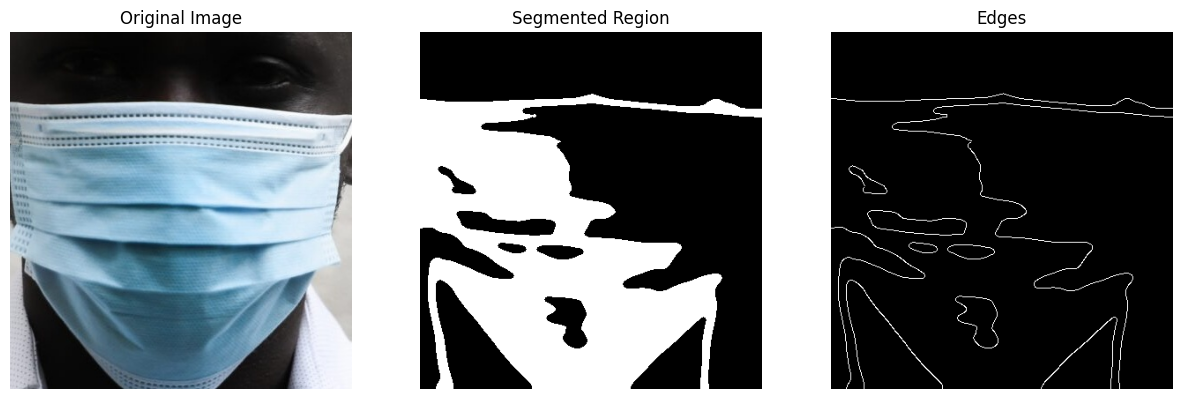

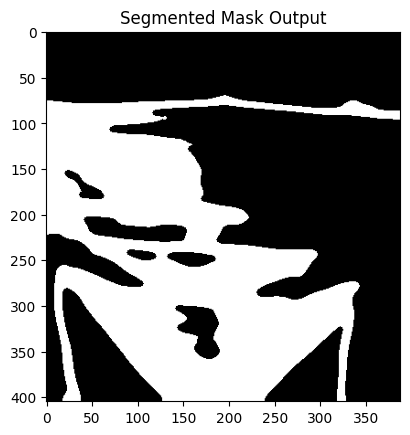

In [8]:
import matplotlib.pyplot as plt
import cv2


pred_mask = segment_region_growing(image_path, viz=True, tolerance=0.19)

if pred_mask is None:
    print("Error: Segmentation function returned None")
else:
    plt.imshow(pred_mask, cmap='gray')
    plt.title("Segmented Mask Output")
    plt.show()


In [10]:
def compute_metrics(pred_mask, true_mask_path):
    """Calculate IoU and Dice Score between predicted and ground truth masks."""
    
    # Load ground truth mask
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
    
    if true_mask is None:
        print(f"Skipping {true_mask_path} (Ground truth not found)")
        return None

    # Convert to binary masks
    pred_binary = (pred_mask > 0).astype(np.uint8)
    true_binary = (true_mask > 0).astype(np.uint8)

    # Compute intersection and union
    intersection = np.logical_and(pred_binary, true_binary).sum()
    union = np.logical_or(pred_binary, true_binary).sum()
    iou_score = intersection / union if union > 0 else 0

    # Compute Dice coefficient
    dice_score = (2 * intersection) / (pred_binary.sum() + true_binary.sum()) if (pred_binary.sum() + true_binary.sum()) > 0 else 0

    return {"IoU": iou_score, "Dice": dice_score}

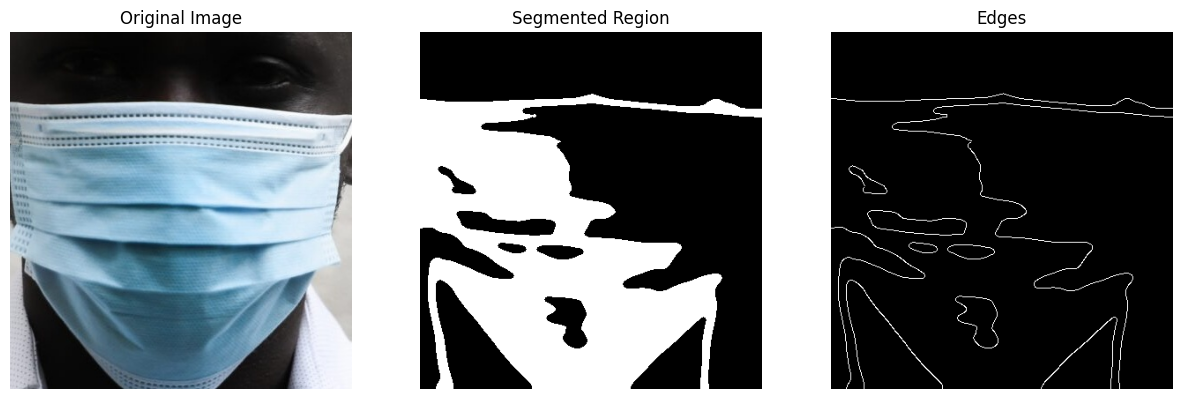

{'IoU': np.float64(0.53602498122745), 'Dice': np.float64(0.6979378431711548)}


In [11]:
# Perform segmentation using region growing method
segmented_output = segment_region_growing(
    image_path='../dataset_my/MSFD/1/face_crop/000000_1.jpg',
    viz=True,
    tolerance=0.19
)

# Define the corresponding ground truth mask path
ground_truth_path = '../dataset_my/MSFD/1/face_crop_segmentation/000000_1.jpg'

# Compute and display segmentation evaluation metrics
evaluation_results = compute_metrics(segmented_output, ground_truth_path)
print(evaluation_results)


### Batch Segmentation and Evaluation  
Processes images from a folder, generates masks, and computes IoU and Dice scores.  
Handles missing files, dimension mismatches, and calculates average metrics.  

### Compute IoU and Dice Score  
Calculates overlap between predicted and ground truth masks using IoU and Dice coefficient.  
Handles binary conversion and ensures valid mask loading.  


In [12]:
total_iou, total_dice, processed_images = 0, 0, 0  # Initialize counters

# Iterate through all images in the input folder
for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only images
        image_path = os.path.join(input_dir, filename)
        mask_path = os.path.join(gt_dir, filename)  # Assume same filename
        
        if not os.path.exists(mask_path):
            print(f"Skipping {filename} (Ground truth missing)")
            continue

        # Generate segmentation mask with a different tolerance value
        predicted_mask = segment_region_growing(image_path=image_path, tolerance=0.25)

        # Load ground truth mask
        actual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        if actual_mask is None:
            print(f"Skipping {filename} (Failed to load ground truth mask)")
            continue

        # Ensure both masks have the same dimensions
        if predicted_mask.shape != actual_mask.shape:
            print(f"Skipping {filename} (Dimension mismatch: {predicted_mask.shape} vs {actual_mask.shape})")
            continue

        # Compute evaluation metrics
        results = compute_metrics(predicted_mask, mask_path)
        if results:
            total_iou += results["IoU"]
            total_dice += results["Dice"]
            processed_images += 1  

# Calculate and display average IoU and Dice scores by dividing the totals by the number of processed images
if processed_images > 0:
    print(f"\nAverage IoU: {total_iou / processed_images:.4f}, Average Dice: {total_dice / processed_images:.4f}")
else:
    print("\nNo images were successfully processed.")


Skipping 000601_1.jpg (Ground truth missing)
Skipping 007541_1.jpg (Dimension mismatch: (129, 172) vs (128, 172))

Average IoU: 0.3997, Average Dice: 0.5365


### Otsu Thresholding-Based Segmentation  
Applies Otsu's method with morphological processing for mask generation.  
Processes a dataset, evaluates IoU and Dice scores, and handles missing files.  


In [13]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import binary_closing, disk

# Define dataset paths
input_dir = os.path.join("..", "dataset_my", "MSFD", "1", "face_crop")
gt_dir = os.path.join("..", "dataset_my", "MSFD", "1", "face_crop_segmentation")

def segment_otsu_thresholding(image_path):
    """Perform segmentation using Otsu's Thresholding and Morphological Processing."""
    
    # Load image
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Skipping {image_path} (Image not found)")
        return None

    # Apply Gaussian Blur to remove noise
    blurred = cv2.GaussianBlur(image, (5, 5), 0)

    # Apply Otsu's Thresholding
    _, binary_mask = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

    # Apply Morphological Closing to refine segmentation
    processed_mask = binary_closing(binary_mask // 255, disk(5)).astype(np.uint8) * 255

    return processed_mask

def compute_metrics(pred_mask, true_mask_path):
    """Calculate IoU and Dice Score between predicted and ground truth masks."""
    
    # Load ground truth mask
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)
    
    if true_mask is None:
        print(f"Skipping {true_mask_path} (Ground truth not found)")
        return None

    # Convert to binary masks
    pred_binary = (pred_mask > 0).astype(np.uint8)
    true_binary = (true_mask > 0).astype(np.uint8)

    # Compute intersection and union
    intersection = np.logical_and(pred_binary, true_binary).sum()
    union = np.logical_or(pred_binary, true_binary).sum()
    iou_score = intersection / union if union > 0 else 0

    # Compute Dice coefficient
    dice_score = (2 * intersection) / (pred_binary.sum() + true_binary.sum()) if (pred_binary.sum() + true_binary.sum()) > 0 else 0

    return {"IoU": iou_score, "Dice": dice_score}

# Run segmentation on dataset
total_iou, total_dice, processed_images = 0, 0, 0  

for filename in os.listdir(input_dir):
    if filename.lower().endswith(('.png', '.jpg', '.jpeg')):  # Process only images
        image_path = os.path.join(input_dir, filename)
        mask_path = os.path.join(gt_dir, filename)  # Assume same filename
        
        if not os.path.exists(mask_path):
            print(f"Skipping {filename} (Ground truth missing)")
            continue

        # Perform segmentation
        predicted_mask = segment_otsu_thresholding(image_path)
        if predicted_mask is None:
            continue

        # Load ground truth mask
        actual_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if actual_mask is None:
            print(f"Skipping {filename} (Failed to load ground truth mask)")
            continue

        # Ensure dimensions match
        if predicted_mask.shape != actual_mask.shape:
            print(f"Skipping {filename} (Dimension mismatch: {predicted_mask.shape} vs {actual_mask.shape})")
            continue

        # Compute evaluation metrics
        results = compute_metrics(predicted_mask, mask_path)
        if results:
            total_iou += results["IoU"]
            total_dice += results["Dice"]
            processed_images += 1  

# Display average IoU and Dice scores
if processed_images > 0:
    print(f"\nAverage IoU: {total_iou / processed_images:.4f}, Average Dice: {total_dice / processed_images:.4f}")
else:
    print("\nNo images were successfully processed.")


Skipping 000601_1.jpg (Ground truth missing)
Skipping 007541_1.jpg (Dimension mismatch: (129, 172) vs (128, 172))

Average IoU: 0.3156, Average Dice: 0.4430
